In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent))

from preprocess import VN30, preprocess_v1

# Bước 1: Tiền xử lý dữ liệu

In [2]:
_ = preprocess_v1("ACB", val=0.0, verbose=True)

=== Preprocessing ACB ===
Train shape: (1213, 201), Val shape: (0, 201), Test shape: (296, 201)


# Bước 2: Huấn luyện mô hình
* LinearRegression (lag = 1 to 30)
* LinearRegression (lag = 30, 7 flags), $R^2$ -> linear.csv

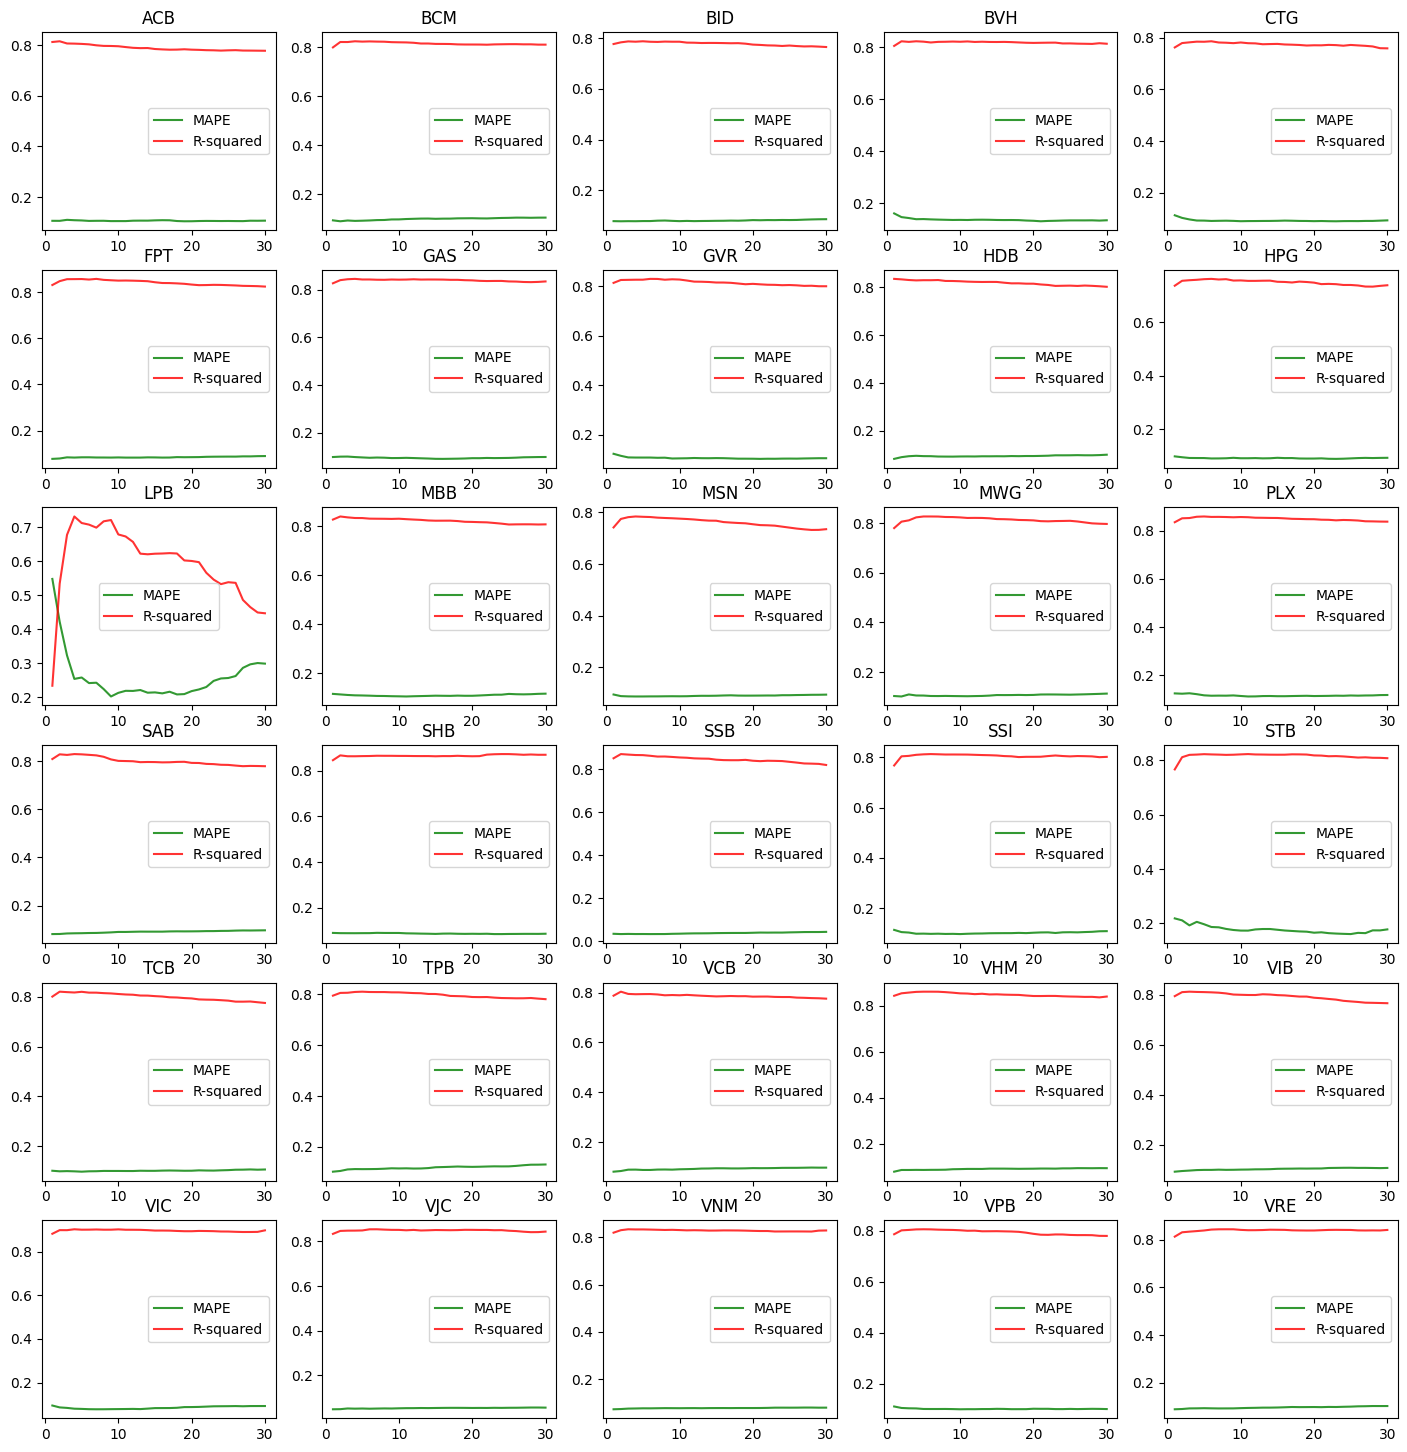

In [3]:
from typing import Iterable

from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from RVFL.utils import Metrics, metrics

TOTAL_LAGS = 30

def variable_lag(symbol: str) -> Iterable[Metrics]:
    model = LinearRegression()

    for lag in range(1, 1 + TOTAL_LAGS):
        packed = preprocess_v1(
            symbol,
            lag=lag,
            val=0.0,
            calendar_feature=False,
            rolling_feature=False,
            technical_feature=False,
            nonlinear_feature=False,
            autocorr_feature=False,
            trend_feature=False,
        )
        x_train, y_train = packed["train"]
        x_test, y_test = packed["test"]
        target_scaler = packed["scaler"]["target"]

        model.fit(x_train, y_train)
        yield metrics(
            target_scaler.inverse_transform(y_test),
            target_scaler.inverse_transform(model.predict(x_test)),
        )

rows = 6
cols = 5
fig, axes = pyplot.subplots(rows, cols, figsize=(cols * 3.5, rows * 3))

for symbol, ax in zip(VN30, axes.ravel(), strict=True):    
    all_metrics = list(variable_lag(symbol))
    # rmse = [m["rmse"] for m in all_metrics]
    mape = [m["mape"] for m in all_metrics]
    r2 = [m["r2"] for m in all_metrics]
    x_values = range(1, 1 + TOTAL_LAGS)

    # ax.plot(x_values, rmse, label="RMSE", color="blue", alpha=0.8)
    ax.plot(x_values, mape, label="MAPE", color="green", alpha=0.8)
    ax.plot(x_values, r2, label="R-squared", color="red", alpha=0.8)

    ax.legend()
    ax.set_title(symbol)

pyplot.show()

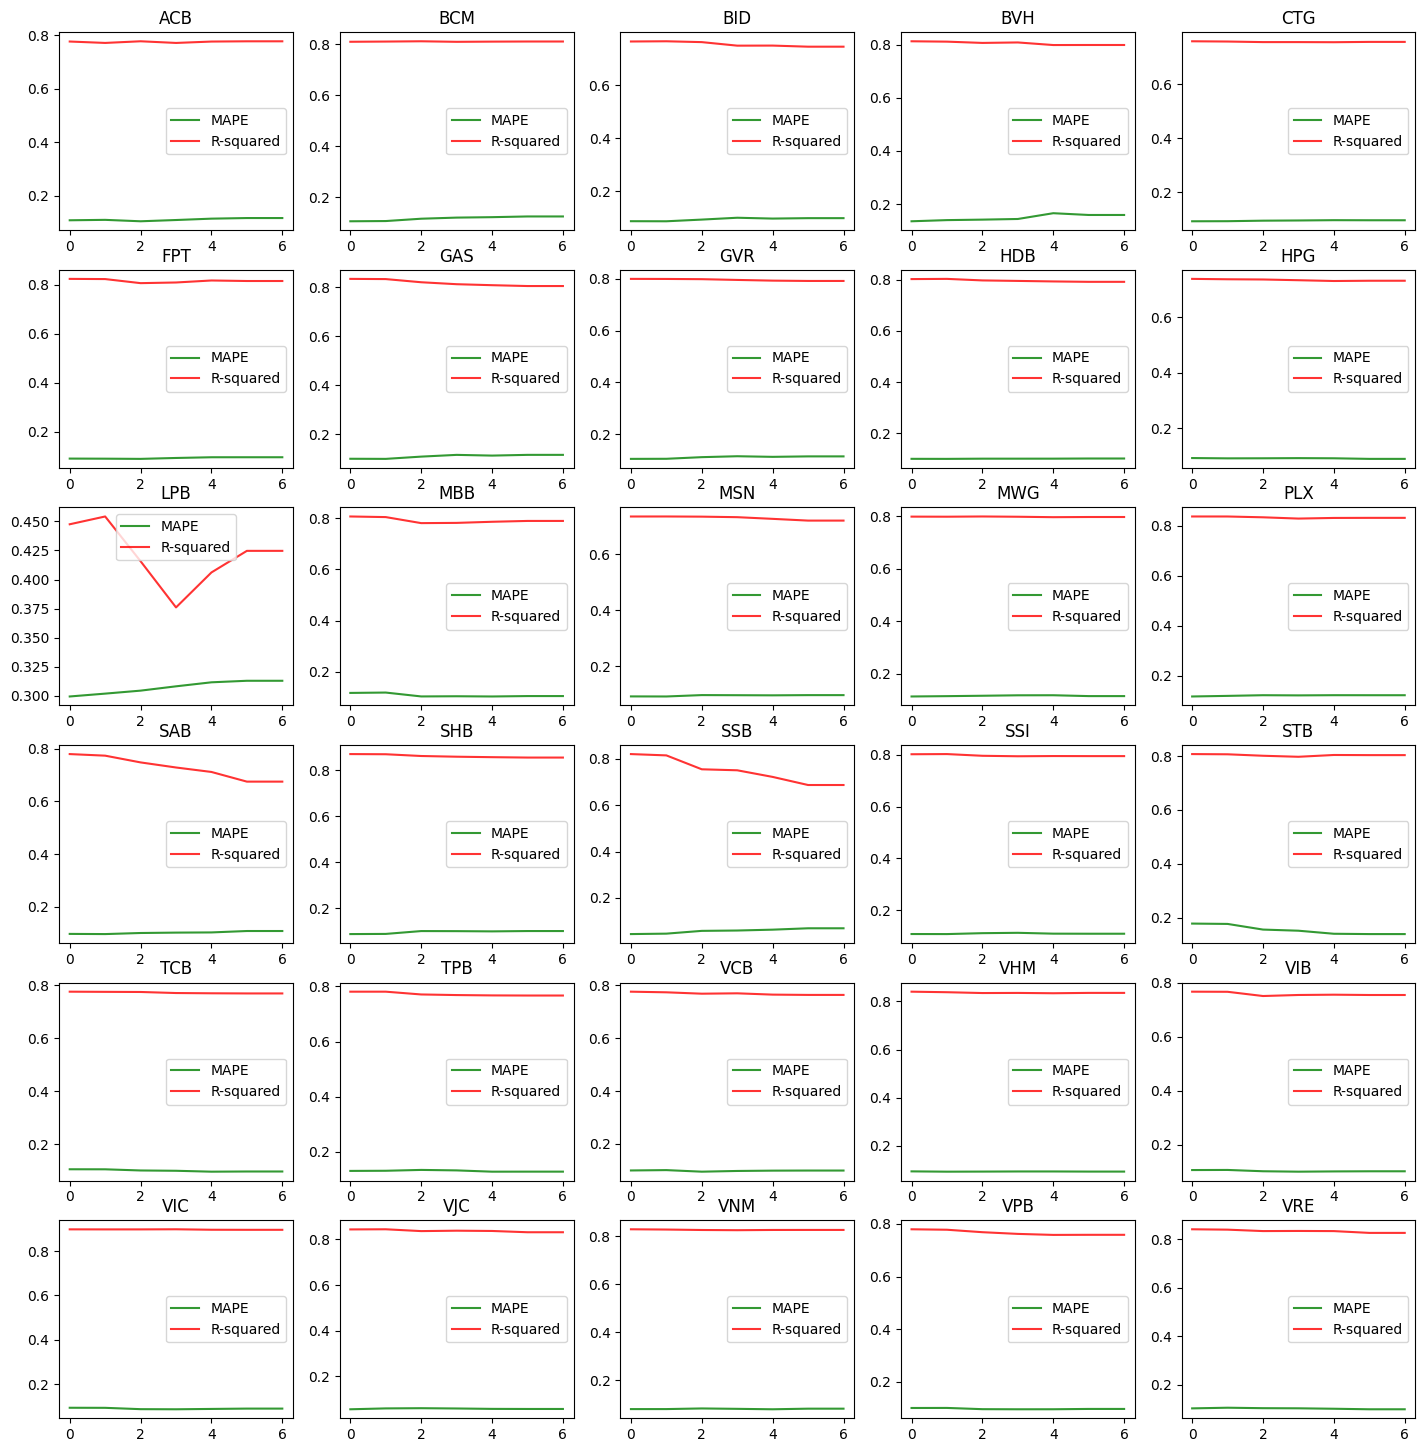

In [4]:
import io

TOTAL_FLAGS = 6

def variable_flags(symbol: str) -> Iterable[Metrics]:
    model = LinearRegression()

    for flags in range(1 + TOTAL_FLAGS):
        args = [True] * flags + [False] * (TOTAL_FLAGS - flags)

        packed = preprocess_v1(symbol, 30, 0, *args)
        x_train, y_train = packed["train"]
        x_test, y_test = packed["test"]
        target_scaler = packed["scaler"]["target"]

        model.fit(x_train, y_train)
        yield metrics(
            target_scaler.inverse_transform(y_test),
            target_scaler.inverse_transform(model.predict(x_test)),
        )

rows = 6
cols = 5
fig, axes = pyplot.subplots(rows, cols, figsize=(cols * 3.5, rows * 3))

with open("linear.csv", "w", encoding="utf-8", buffering=1) as writer:
    writer.write("sep=,\n[R-squared] Flags,")
    writer.write(",".join(VN30))
    writer.write("\n")

    rows = [io.StringIO(str(i)) for i in range(1 + TOTAL_FLAGS)]
    for row in rows:
        row.seek(0, 2)

    for symbol, ax in zip(VN30, axes.ravel(), strict=True):    
        all_metrics = list(variable_flags(symbol))

        # rmse = [m["rmse"] for m in all_metrics]
        mape = [m["mape"] for m in all_metrics]
        r2 = [m["r2"] for m in all_metrics]
        for row, r in zip(rows, r2, strict=True):
            row.write(f",{r}")

        x_values = range(1 + TOTAL_FLAGS)

        # ax.plot(x_values, rmse, label="RMSE", color="blue", alpha=0.8)
        ax.plot(x_values, mape, label="MAPE", color="green", alpha=0.8)
        ax.plot(x_values, r2, label="R-squared", color="red", alpha=0.8)

        ax.legend()
        ax.set_title(symbol)

    for row in rows:
        row.seek(0)
        writer.write(row.read())
        writer.write("\n")

pyplot.show()

# Bước 3: Đánh giá mô hình

# Đánh giá toàn bộ dữ liệu